In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import scipy.ndimage as scipy
import matplotlib.pyplot as plt

In [2]:
people = 103
photos = 12 

data_photo = []
data_labels = []

In [3]:
photo_path = 'dataset/images'
labels_path = 'dataset/labels'

In [4]:
for i in range(people):
    photo_list = []
    frac_list = []
    if i < 9:
      txt_path = labels_path + f'/00{i+1}_image_labels.txt'
      png_1 = f'/00{i+1}'
    elif 9 >= i < 99:
      txt_path = labels_path + f'/0{i+1}_image_labels.txt'
      png_1 = f'/0{i+1}'
    elif i >= 99:
      txt_path = labels_path + f'/{i+1}_image_labels.txt'
      png_1 = f'/{i+1}'
    with open(txt_path, 'r') as f:
        label_list = f.readlines()
    for j in range(photos):
        frac_list.append(label_list[j].split()[1:])
        if j < 9:
          png_2 = f'_0{j+1}.png'
        elif j>= 9:
          png_2 = f'_{j+1}.png'
        png_path = photo_path + png_1 + png_2
        photo_list.append(cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)) 
    data_labels.append(frac_list)
    data_photo.append(photo_list)

data_labels = np.array(data_labels)
float_data_labels = data_labels.astype(float)

data_labels = float_data_labels.astype(int)
data_photo = np.array(data_photo)

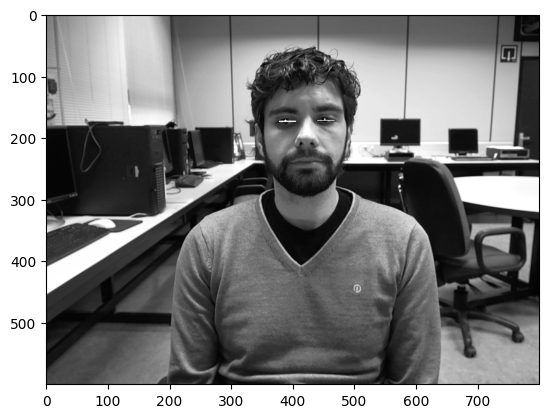

In [5]:
user_num = 5   
photo_num = 5

template = data_photo[user_num][photo_num ].copy()

cv2.rectangle(template, (data_labels[user_num][photo_num][0], data_labels[user_num][photo_num][1]), (data_labels[user_num][photo_num ][4],  data_labels[user_num][photo_num ][5]), (255, 0, 0), thickness=1 ) 
cv2.circle(template, (data_labels[user_num][photo_num ][2], data_labels[user_num][photo_num][3]), 1, (255,0,0), thickness=-1)
cv2.rectangle(template, (data_labels[user_num][photo_num ][6], data_labels[user_num][photo_num][7]), (data_labels[user_num][photo_num ][10], data_labels[user_num][photo_num ][11]), (255, 0, 0), thickness=1 )
cv2.circle(template, (data_labels[user_num][photo_num ][8], data_labels[user_num][photo_num][9]), 1, (255,0,0), thickness=-1)

plt.imshow(template, cmap = 'gray')

In [6]:
data_photo = data_photo.reshape(103*12,600,800)
data_labels = data_labels.reshape(103*12,12)

blank = np.zeros((600,800), dtype='uint8')
x = []
y = []

for i in range(people * photos):
  left_center_x = data_labels[i][0] - abs(data_labels[i][0] - data_labels[i][4]) // 2
  left_center_y = data_labels[i][1] - abs(data_labels[i][1] - data_labels[i][5]) // 2
  left_eye = data_photo[i][left_center_y -24 : left_center_y + 24  , left_center_x - 24: left_center_x + 24 ] 
  x.append(left_eye)

  left_iris_x = data_labels[i][2] - (left_center_x - 24)
  left_iris_y = data_labels[i][3] - (left_center_y - 24)
  left_iris = blank.copy()[left_center_y - 24 :left_center_y + 24  , left_center_x - 24: left_center_x + 24 ]
  left_iris[left_iris_x, left_iris_y] = 255
  left_iris = scipy.gaussian_filter(left_iris, sigma = 1)
  left_iris = left_iris * 4 
  y.append(left_iris)

  right_center_x = data_labels[i][6] - abs(data_labels[i][10] - data_labels[i][6]) // 2
  right_center_y = data_labels[i][7] - abs(data_labels[i][11] - data_labels[i][7]) // 2
  right_eye = data_photo[i][right_center_y - 24 : right_center_y + 24  , right_center_x - 24: right_center_x + 24 ]
  x.append(right_eye)

  right_iris_x = data_labels[i][8] - (right_center_x - 24)
  right_iris_y = data_labels[i][9] - (right_center_y - 24)
  right_iris = blank.copy()[right_center_y - 24 : right_center_y + 24  , right_center_x - 24: right_center_x + 24 ]
  right_iris[right_iris_x, right_iris_y] = 255
  right_iris = scipy.gaussian_filter(right_iris, sigma = 1)
  right_iris = right_iris * 4 
  y.append(right_iris)
 
x = np.array(x)
y = np.array(y)

print(x.shape, y.shape)

(2472, 48, 48) (2472, 48, 48)


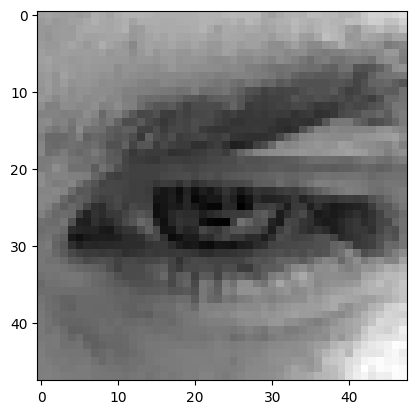

In [7]:
plt.imshow(x[0], cmap = 'gray')

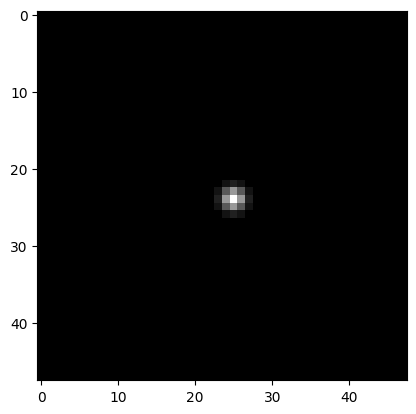

In [8]:
plt.imshow(y[0], cmap = 'gray')


In [9]:
x = x/255
y = y/255

In [10]:
np.random.shuffle(x)
x_train, x_test = x[:1980], x[1980:]
y_train, y_test = y[:1980], y[1980:]
x_train = torch.Tensor(x_train[:, np.newaxis] )
x_test = torch.Tensor(x_test[:, np.newaxis] )
y_train = torch.Tensor(y_train[:, np.newaxis] )
y_test = torch.Tensor(y_test[:, np.newaxis] )

In [12]:
x_train.shape

torch.Size([1980, 1, 48, 48])

In [13]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_dataset = DataLoader(train_dataset, 10)
test_dataset = DataLoader(test_dataset, 10)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 3, padding = 1)             
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1) 
        self.pool1 = nn.MaxPool2d(2, stride = 2)                     
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, stride = 2)  
        self.conv4 = nn.Conv2d(128, 64, 3, padding = 1)
        self.conv5 = nn.Conv2d(64, 1, 3, padding = 1)

        self.t_conv1 = nn.ConvTranspose2d(256, 64, 3, stride = 5, padding = 5)
        self.t_conv2 = nn.ConvTranspose2d(256, 128, 3, stride = 3, padding = 6)
        self.t_conv3 = nn.ConvTranspose2d(128, 64, 3, stride = 3, padding = 12)
        self.t_conv4 = nn.ConvTranspose2d(64, 1, 3, stride=1, padding = 1)

    def forward(self, x, a_func):
        x = a_func(self.conv1(x))
        x_skip = x
        x = a_func(self.pool1(self.conv2(x)))
        x = a_func(self.pool2(self.conv3(x)))
        y = x
        x = a_func(self.t_conv1(y))
      
        x = torch.cat((x, x_skip), 1)
        x = a_func(self.conv4(x))
        x = F.sigmoid(self.conv5(x))

        y = a_func(self.t_conv2(y))
        y = a_func(self.t_conv3(y))
        y = F.sigmoid(self.t_conv4(y))
        return x, y


In [15]:
torch_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch_cuda else "cpu")
model_cnn = CNN().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of params in the CNN model:", count_parameters(model_cnn))

Number of params in the CNN model: 960962


In [22]:
def train( model, device, train_loader, a_func, loss_func, optimizer, generations):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output_1, output_2 = model(data, a_func)
        loss_1 = loss_func(output_1[:,:,12:36,12:36], target[:,:,12:36,12:36]) 
        loss_2 = loss_func(output_2, data) 
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()
    return loss.item()

In [23]:
def test( model, device, a_func, loss_func, test_loader):
    model.eval()
    test_loss, loss1, loss2 = 0,0,0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output_1, output_2  = model(data, a_func)
            loss1 += loss_func(output_1[:,:,12:36,12:36], target[:,:,12:36,12:36], reduction = 'sum').item() 
            loss2 += loss_func(output_2, data, reduction = 'sum').item() 

    test_loss = loss1 + loss2
    test_loss /= len(test_loader.dataset) * 10
 
    return test_loss

In [24]:
generations = 30
lr = 0.01
momentum = 0.5
log_interval = 700 


model_cnn = CNN().to(device)
model = model_cnn
optimizer = optim.Adam(model.parameters())

trainning_error, test_error = [], []

for generation in range(1, generations + 1):
    trainning_error.append(train(model, device, train_dataset, F.tanh, F.mse_loss, optimizer, generation))
    test_error.append(test(model, device, F.tanh, F.mse_loss, test_dataset))

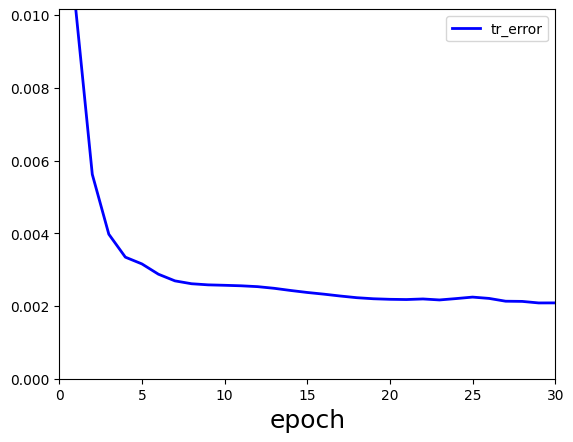

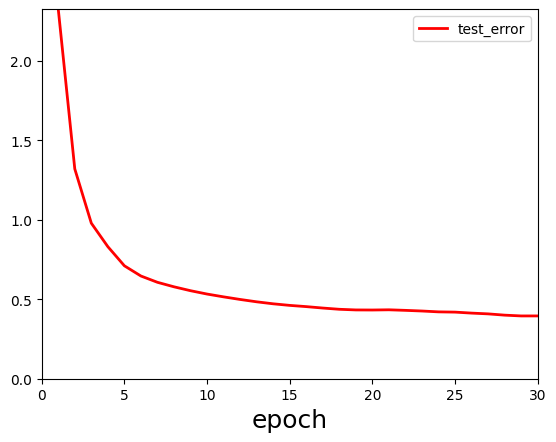

In [27]:
generation_list = np.arange(1,generations + 1)



plt.figure()
plt.plot(generation_list,trainning_error, linewidth=2, color = 'blue', label="trainning error")
plt.xlabel('generation', fontsize=18)
plt.xlim([0, max(generation_list)])
plt.ylim([0,max(trainning_error)])
plt.legend()
plt.show()

plt.figure()
plt.plot(generation_list,test_error, linewidth=2, color = 'red', label="test error")
plt.xlabel('generation', fontsize=18)
plt.xlim([0, max(generation_list)])
plt.ylim([0,max(test_error)])
plt.legend()
plt.show()


In [38]:
for i in range(30):
    print(f'{i + 1}: {trainning_error[i]}')

1: 0.010162783786654472
2: 0.005619455128908157
3: 0.0039734444580972195
4: 0.003342466428875923
5: 0.0031571697909384966
6: 0.002873685210943222
7: 0.002690449822694063
8: 0.0026117663364857435
9: 0.0025811437517404556
10: 0.002569136442616582
11: 0.002555255312472582
12: 0.0025317028630524874
13: 0.0024863658472895622
14: 0.0024262957740575075
15: 0.0023718117736279964
16: 0.0023255455307662487
17: 0.002273918129503727
18: 0.002227908233180642
19: 0.002198814647272229
20: 0.0021836489904671907
21: 0.0021773329935967922
22: 0.0021932669915258884
23: 0.0021661072969436646
24: 0.0022034221328794956
25: 0.0022443823982030153
26: 0.002208147430792451
27: 0.0021314057521522045
28: 0.0021261677611619234
29: 0.0020837571937590837
30: 0.002084872452542186


In [37]:
for i in range(30):
    print(f'{i + 1}: {test_error[i] }')

1: 2.326928969708885
2: 1.3208503328687777
3: 0.9792574860700747
4: 0.8313045197386083
5: 0.7109807468526732
6: 0.6466288580642483
7: 0.6069893031100917
8: 0.5786896356722203
9: 0.5541472242130496
10: 0.5330484476031326
11: 0.5153856837652563
12: 0.4990272516157569
13: 0.484202618133731
14: 0.47165050521129515
15: 0.46170723530335156
16: 0.45394535651051904
17: 0.4449728766107947
18: 0.4371519347758797
19: 0.43308041812927744
20: 0.4325943613682336
21: 0.4339319061215331
22: 0.4303801405720594
23: 0.4262609039138003
24: 0.42091612227079345
25: 0.4193128572973779
26: 0.41310619297550943
27: 0.40826258126313125
28: 0.40024951991996144
29: 0.395266885461846
30: 0.39533265000436363


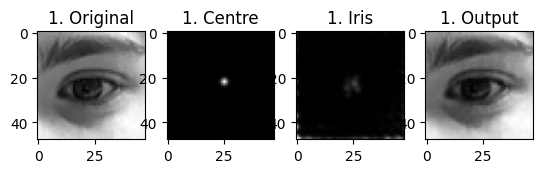

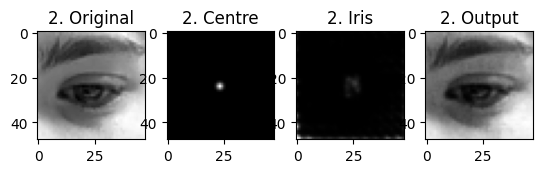

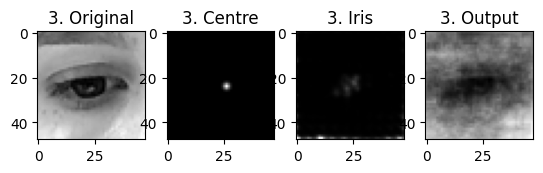

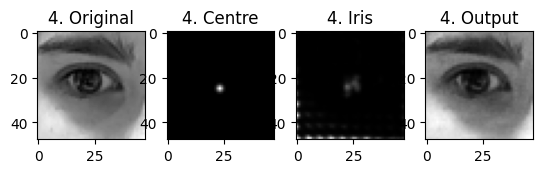

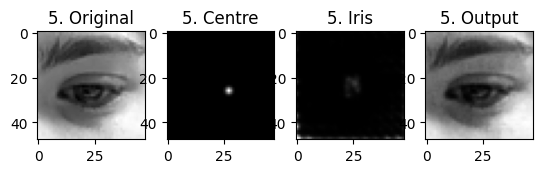

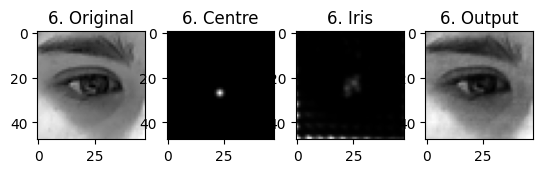

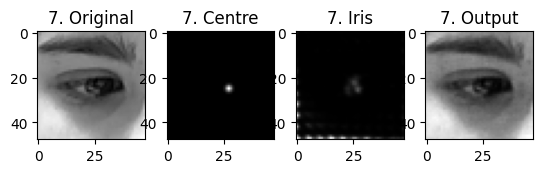

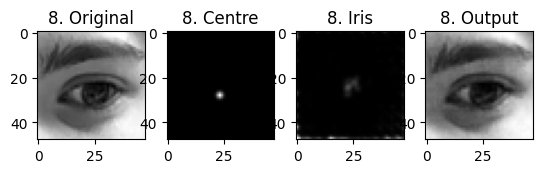

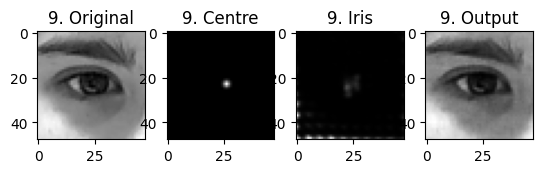

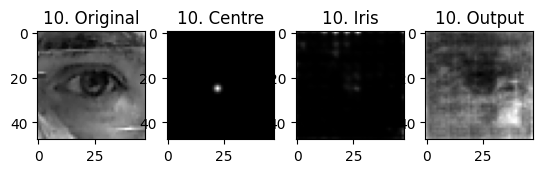

In [40]:
model.eval()
with torch.no_grad():
  for data, center in test_dataset:
    data, target = data.to(device), center.to(device)
    iris, output  = model(data, F.tanh)
    for i in range(10):
      fig, axis = plt.subplots(1, 4)
      axis[0].imshow(data.cpu().detach()[i][0], cmap="gray")
      axis[0].set_title(f'{i+1}. Original')
      axis[1].imshow(center.cpu().detach()[i][0], cmap="gray")
      axis[1].set_title(f'{i+1}. Centre')
      axis[2].imshow(iris.cpu().detach()[i][0], cmap="gray")
      axis[2].set_title(f'{i+1}. Iris')
      axis[3].imshow(output.cpu().detach()[i][0], cmap="gray")
      axis[3].set_title(f'{i+1}. Output')
    break

In [29]:
max_list = []
photo_list = []
for i in range(10):
    j = int(torch.argmax(iris[i,0,12:36,12:36]))
    max_list.append(np.unravel_index(j, (24,24)))
    ex = np.array(data.cpu().detach()[i][0])
    photo_list.append(ex)
print(max_list)

[(11, 14), (11, 14), (10, 13), (12, 10), (11, 14), (11, 13), (14, 15), (12, 11), (13, 10), (13, 14)]


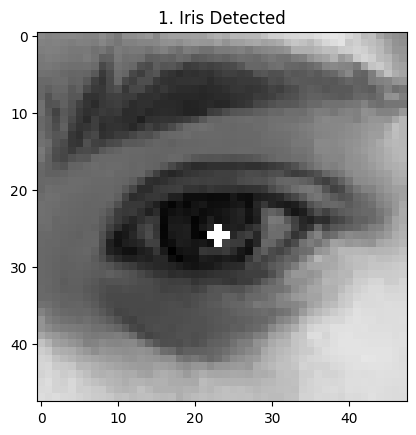

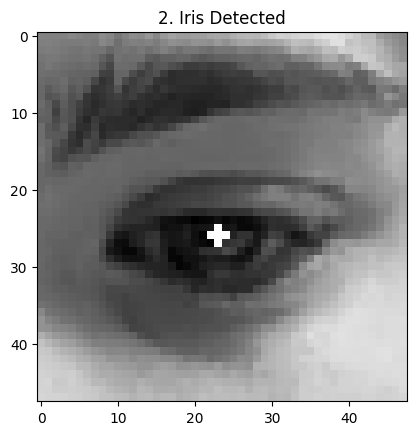

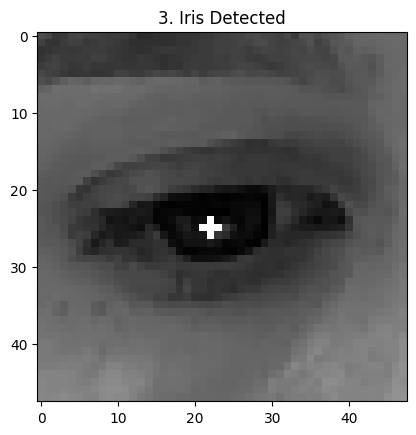

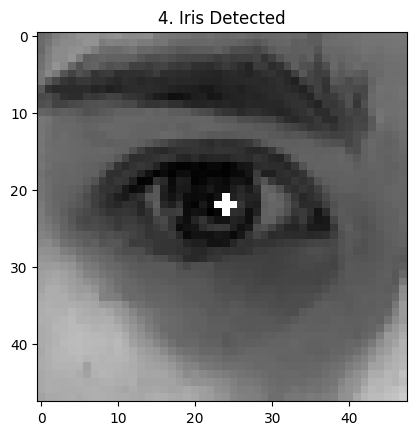

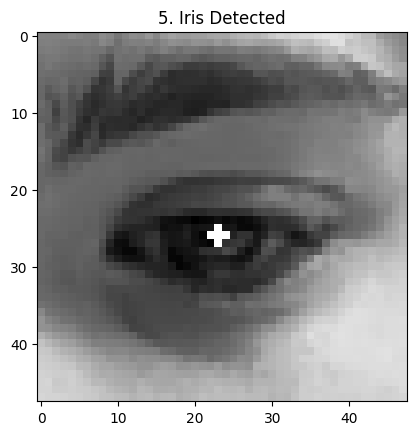

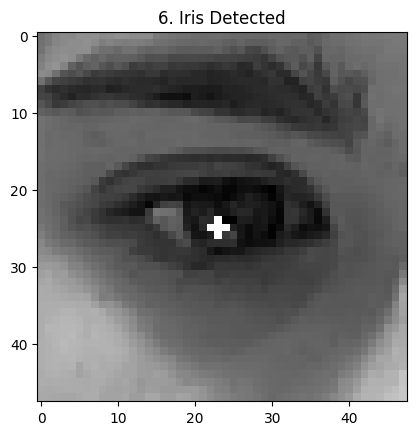

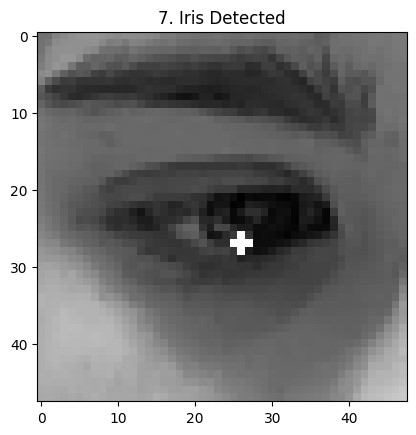

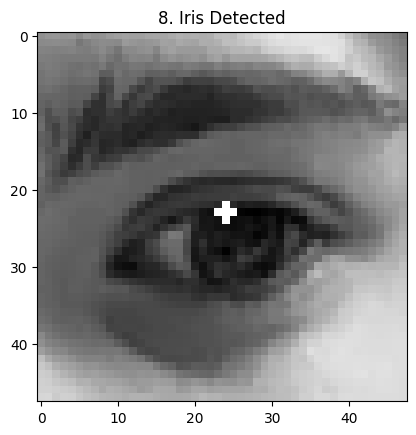

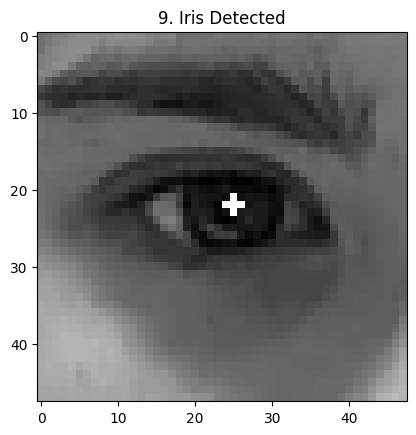

In [42]:
for i in range(9):
    cv2.circle(photo_list[i][12:36,12:36], (max_list[i][0], max_list[i][1]), 1, (1,0,0), thickness=-1)
    fig, axis = plt.subplots(1, 1)
    axis.imshow(photo_list[i], cmap="gray")
    axis.set_title(f'{i+1}. Iris Detected')